- Created by Linna An, 2020/08/29, for 'De novo protein design using the blueprint builder in Rosetta'
- It is recommend to run cells one-by-one by using shift + enter
- Please note the energy unit used is 'Rosetta energy unit', which is not directly translated to physical terms. 

#### Import all required functions and modules

In [1]:
import os, subprocess, re, glob, math, time
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
import pyrosetta as py
import pyrosetta.rosetta as pyro
from pyrosetta import *
from pyrosetta.rosetta import *
import seaborn as sns
import pandas as pd
from itertools import product
from matplotlib.pyplot import hist

init()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.display import IFrame

PyRosetta-4 2020 [Rosetta PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release 2020.15+release.3121c734db02d2b62dd1974dcb8daface3f50057 2020-04-10T09:29:24] retrieved from: http://www.pyrosetta.org
(C) Copyright Rosetta Commons Member Institutions. Created in JHU by Sergey Lyskov and PyRosetta Team.
core.init: {0} Checking for fconfig files in pwd and ./rosetta/flags
core.init: {0} Rosetta version: PyRosetta4.conda.linux.cxx11thread.serialization.CentOS.python37.Release r251 2020.15+release.3121c73 3121c734db02d2b62dd1974dcb8daface3f50057 http://www.pyrosetta.org 2020-04-10T09:29:24
core.init: {0} command: PyRosetta -ex1 -ex2aro -database /home/linna/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/pyrosetta/database
basic.random.init_random_generator: {0} 'RNG device' seed mode, using '/dev/urandom', seed=1470947520 seed_offset=0 real_seed=1470947520 thread_index=0
basic.random.init_random_generator: {0} RandomGenerator:init: Normal mode, seed=1470947520 RG

### Supply user path to the score file

In [6]:
#--------
#User path input
#--------
WORK_DIR = '..' #Here is the path you should change to your own path, '..' means upper directory 
print('You are currently in path {}'.format(os.getcwd()))
score_file = WORK_DIR+'/seq_result/score_seq.sc'
print('The score file path user supplied is: \n{}.\nDoes the score file exist? {}'.format(score_file,os.path.isfile(score_file)))
print('Only proceed if the previous answer is True!')

You are currently in path /home/linna/digs_home/linnaan/Manuscript/2020_CurrProtocolProteinSci/GyuRie_barrel_script/LA_demos/demo_seq/scripts
The score file path user supplied is: 
../seq_result/score_seq.sc.
Does the score file exist? True
Only proceed if the previous answer is True!


### Read the score file

In [7]:
# Load scores and make plots
df = pd.read_csv(score_file, header=1, delim_whitespace=True)
print('All score terms measured {}'.format(df.columns))
print('The number of protein made {}'.format(len(df)))

All score terms measured Index(['SCORE:', 'total_score', 'angle_constraint', 'atom_pair_constraint',
       'chainbreak', 'coordinate_constraint', 'dihedral_constraint',
       'dslf_fa13', 'fa_atr', 'fa_dun', 'fa_elec', 'fa_intra_rep',
       'fa_intra_sol_xover4', 'fa_rep', 'fa_sol', 'hbond_bb_sc', 'hbond_lr_bb',
       'hbond_sc', 'hbond_sr_bb', 'lk_ball_wtd', 'metalbinding_constraint',
       'omega', 'p_aa_pp', 'pro_close', 'rama_prepro', 'ref',
       'res_type_constraint', 'yhh_planarity', 'description'],
      dtype='object')
The number of protein made 6


### Select the score terms you care about
- While only three score terms were used as example here, you can select other score terms or filters based on your needs.
- 'total_score' summuarized for all types of measurements. It is also recommended to check score_per_res.
- 'omega' is the score term measuring if the peptide bond is ideal.
- 'rama_prepro' measures if the location of proline is reasonble. 

In [9]:
relevant_features = ['total_score','omega','rama_prepro']
print('The selected score terms are {}'.format(relevant_features))

The selected score terms are ['total_score', 'omega', 'rama_prepro']


- Sometimes, there might be random strings/lines inserted into socre file table, which may create errors during data import, remove them before data import if that's the case.

### Display the distribution of the selected score terms

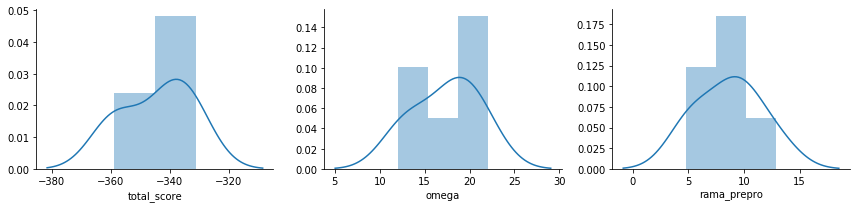

In [10]:
ncols = 3
nrows = math.ceil(len(relevant_features) / ncols)
(fig, axs) = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=[12,3*nrows]
)
axs = axs.reshape(-1)

for (i, metric) in enumerate(relevant_features):
    sns.distplot(df[metric], ax=axs[i])
    
sns.despine()
plt.tight_layout()
plt.show()

### Filter by metrics. 
- In this demo, we only demonstrated selecting based on a rough cutoff for selected metrix due to limit number of input proteins. It is recommended to filter based on fraction for each score term. You may also select a score cutoff based on the distribution of the scores.

In [15]:
cutoffs_smaller_than = {}
energies_smaller_than = {'total_score':(-350),'omega':(18),'rama_prepro':(10)} #you may change the score cutoff here
cutoffs_smaller_than.update(energies_smaller_than) 

print(cutoffs_smaller_than)

{'total_score': -350, 'omega': 18, 'rama_prepro': 10}


### Display the score features of the selected pdb

/home/linna/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/linna/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/linna/anaconda3/envs/pyrosetta_env/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


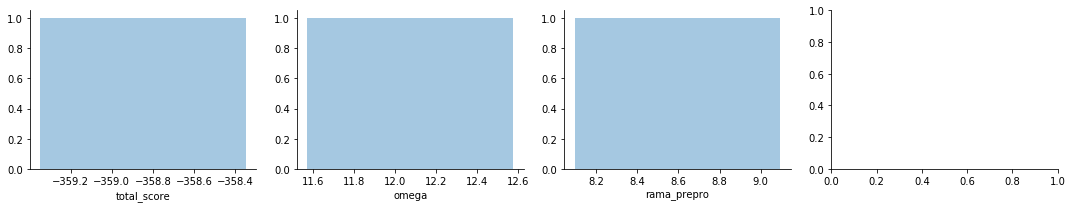

1 proteins passed filter


,SCORE:,total_score,angle_constraint,atom_pair_constraint,chainbreak,coordinate_constraint,dihedral_constraint,dslf_fa13,fa_atr,fa_dun,...,lk_ball_wtd,metalbinding_constraint,omega,p_aa_pp,pro_close,rama_prepro,ref,res_type_constraint,yhh_planarity,description
3,SCORE:,-358.847,0.0,3.515,0.0,0.0,0.0,0.0,-612.126,131.778,...,-2.413,0.0,12.075,-36.104,0.947,8.595,39.443,0.0,0.013,input_demo_0007_seq_0001


In [17]:
dfsub = df.copy()

for cutoff in cutoffs_smaller_than:
    dfsub = dfsub[dfsub[cutoff] < cutoffs_smaller_than[cutoff]]


ncols = 4
nrows = math.ceil(len(relevant_features) / ncols)
(fig, axs) = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=[15,3*nrows]
)
axs = axs.reshape(-1)
for (i, metric) in enumerate(relevant_features):
    if len(dfsub[metric])==0:
        continue
    try:
        sns.distplot(dfsub[metric], ax=axs[i])
    except:
        print("failed for ", metric)
    
sns.despine()
plt.tight_layout()
plt.show()
print('{} proteins passed filter'.format(len(dfsub)))
dfsub

### Move selected pdb to folder ./sel_seq

In [10]:
os.makedirs(WORK_DIR+'/sel_seq',exist_ok=True)
for pdb in dfsub['description']:
    sel_pdb_path = WORK_DIR+'/seq_result/'+pdb+'.pdb'
    cmd = 'cp -n {} {}'.format(sel_pdb_path,WORK_DIR+'/sel_seq')
    subprocess.call('{}'.format(cmd),shell=True)

#### Now you have the designed proteins which passed filter moved to folder sel_seq/